# Logistics Regression with SGD Classifier
**1. Project Overview:**

   (a) To work on multi-logistics regression methodology with regularization (penalty/weight-decay) to predict if banknotes are genuine or forged using SGD Classifier from sci-kit learn.

**2. Dataset:** 

Banknote Authentication Dataset

**3. Sources:**

   (a) Origin:  This dataset was taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#)
                
   (b) Creator: University of Applied Sciences, Ostwestfalen-Lippe, volker.lohweg '@' hs-owl.de
                 
   (c) Date: August, 2012
   
**4. Number of Attributes:**

4 continuous attributes, 1 integer type target attribute.

**5. Attribute Information:**

| Index | Column | Description |
| :-- | :-- | :-- |
|1. | variance | Variance of Wavelet Transformed image |
|2. | skew | Skewness of Wavelet Transformed image |
|3. | curto | Curtosis of Wavelet Transformed image |
|4. | entropy | Entropy of image |
|5. | class | Taget class: "0" for forged and "1" for genuine |

## 1. Importing Libraries

In [1]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler      # Min-Max Normalization
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier      # SGDClassifier - Logistic Regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier  # knn()

%matplotlib inline

## 2. Importing Dataset

In [2]:
# Prepare header
header_lst = ["variance", "skew", "curto", "entropy", "genuine"]

In [3]:
# Import dataset
df = pd.read_csv("raw data/data_banknote_authentication.txt", names = header_lst)

In [4]:
# Check data.head() to ensure import is successful
df.head()

,variance,skew,curto,entropy,genuine
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


### 3. Data Understanding & EDA

- Basic information & data types
- Null values
- Check on numerical values
- Distribution of Target set
- Correlation Matrix between independent variables (predictors) & dependent variable

In [5]:
# Check for basic information & data types
df.info() # 1372 rows & 5 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skew      1372 non-null   float64
 2   curto     1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   genuine   1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [6]:
# Check for NULL values
df.isnull().sum().sort_values(ascending = False)

variance    0
skew        0
curto       0
entropy     0
genuine     0
dtype: int64

In [7]:
# Check on numeric variables summary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skew,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curto,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
genuine,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


[Text(0.5, 0, 'Forged vs. Genuine Notes')]

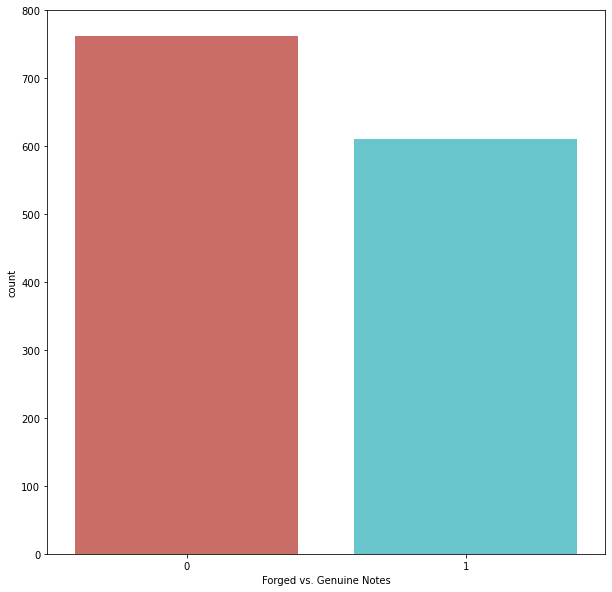

In [8]:
# Check distribution of target label
plt.figure(figsize = (10, 10))     # Size of the figure

ax = sns.countplot(x = "genuine", data = df, palette = "hls")
ax.set(xlabel = "Forged vs. Genuine Notes")

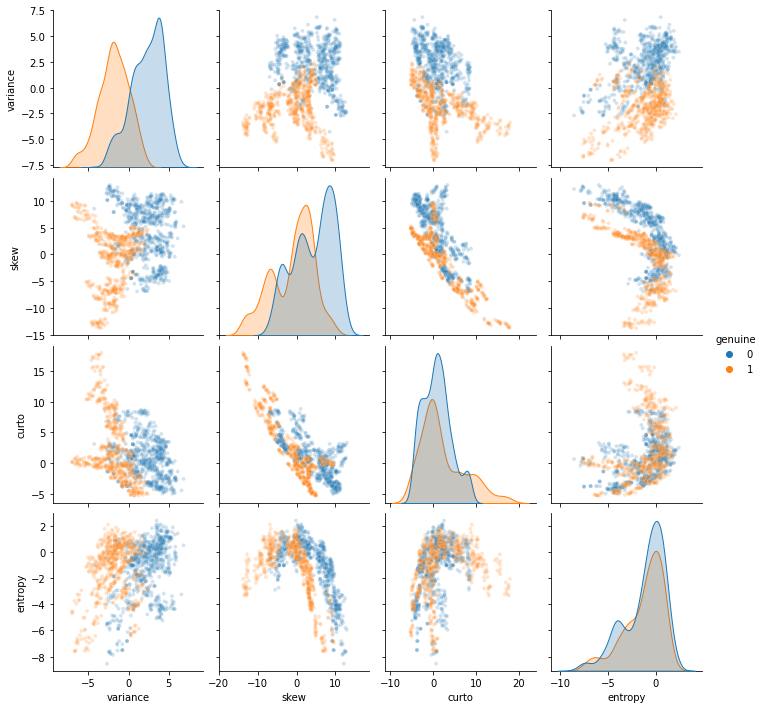

In [9]:
# Plotting pair-plot to see relationship between the variables in dataset
sns.pairplot(data = df, hue = "genuine", plot_kws = {"alpha": 0.2, "s": 15})

**Observations**

- Dataset does not has NULL and all attributes including target variable are numerical values. 
- This will be a classification problem, target column is already in format 0 or 1
- Dataset have no missing values & normalization can be applied if preferred.
- Countplot: Target feature is quite well-balanced
- Pairplot: Most of the variables are pretty well-balanced and the grouping of the target variable are pretty well defined in the pairplot

**Summary:**

- Dataset has to be normalized before building of model, no other pre-processing required

## 3. Data Preparation / Pre-Processing

- Data Normalization on all independent variables (predictors)

In [10]:
# Create object to hold normalized dataframe
df_norm = df

# Instantiate MinMaxScaler object
scaler = MinMaxScaler()

# Normalize all dependent variables
df_norm.iloc[:, :-1] = scaler.fit_transform(df_norm.iloc[:, :-1])

In [11]:
# Check normalized dataset
df_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.539114,0.205003,0.0,0.379977,0.543617,0.711304,1.0
skew,1372.0,0.587301,0.219611,0.0,0.451451,0.602168,0.770363,1.0
curto,1372.0,0.287924,0.185669,0.0,0.159869,0.254280,0.364674,1.0
entropy,1372.0,0.668917,0.191041,0.0,0.557821,0.723929,0.813171,1.0
genuine,1372.0,0.444606,0.497103,0.0,0.000000,0.000000,1.000000,1.0


## 4. Defining our logstics regression

Before we start building and fine-tuning our models, we can first define our model's equation with all the available features/attributes

\begin{equation}
Log(\frac{P(genuine)}{1 - P(genuine)}) = \beta_0 + \beta_1variance + \beta_2skew + \beta_3curto + \beta_4entropy
\end{equation}

**The parameters for our logistic regression are:**

- predictor/dependent label (training & testing)
- Independent variables/features (training & testing)

**The hyperparameters for our logistic regression are:**

- alpha: Constant that multiplies the regularization term, set by the `alpha` hyperparameter
- Regularization / Weight Decay: Method of constraint to penalize complexity of model to reduce overfitting or generalization errors, set by the `penalty` hyperparameter
- epochs: Maximum number of iterations over the training data set by the `max_iter` hyperparameter
- Stopping criterion: The criteria to stop the iterations based on some threshold value and condition based on the difference between the desired output and expected output, set by the `tol` hyperparameter
- Learning Rate: The amount of tuning in optimizing our weight towards a minimum loss, set by the `learning_rate` hyperparameter  

## 5. Splitting the dataset or training-testing set

- Dataset split using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `30% for testing size` and `70% for testing`

In [12]:
# Prepare 70% training & 30% testing dataset
# Set `random_state = 42` for reproducibility
X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1], 
                                                    test_size = 0.3, random_state = 42)

In [13]:
# Checking splitted set
print(f"Ratio of training sets of X_train and y_train are: {len(X_train)/len(df_norm)*100:.2f}% and {len(y_train)/len(df_norm)*100:.2f}%\n"
     f"Ratio of testing sets of X_test and y_test are: {len(X_test)/len(df_norm)*100:.2f}% and {len(y_test)/len(df_norm)*100:.2f}%\n")

Ratio of training sets of X_train and y_train are: 69.97% and 69.97%
Ratio of testing sets of X_test and y_test are: 30.03% and 30.03%



In [14]:
# Check columns of training set
print(X_train.info())
print(f"{'-'*30}")
print(y_train.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 879 to 1126
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  960 non-null    float64
 1   skew      960 non-null    float64
 2   curto     960 non-null    float64
 3   entropy   960 non-null    float64
dtypes: float64(4)
memory usage: 37.5 KB
None
------------------------------
[1 0]


## 6. Building Logistics Regression Model with SGDClassifier

Using the stochastic gradient descent from [sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) for logistic regression on our classification problem, we can build the model for our dataset.

- To ensure reproducibility, we can set our `random_state = 42` so we can reproduce the experiment
- We can evaluate our model with the `classification_report()`


In [15]:
# Building default model

# Initialize default model with no regularization by setting learning_rate to constant
model1 = SGDClassifier(loss = "log", random_state = 42,
                       alpha = 0.0, learning_rate = "constant", eta0 = 0.01)
model1.fit(X_train, y_train)

SGDClassifier(alpha=0.0, eta0=0.01, learning_rate='constant', loss='log',
              random_state=42)

In [16]:
# Perform prediction on training & testing set with default hyperparameters
model1_pred_test = model1.predict(X_test)

In [17]:
# Print accuracy & constructing classification report for default hyperparameter model
print(f"The accuracy of default model on testing set is: {accuracy_score(y_test, model1_pred_test):.2f}%\n")
print(classification_report(y_test, model1_pred_test))

The accuracy of default model on testing set is: 0.96%

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       229
           1       0.97      0.93      0.95       183

    accuracy                           0.96       412
   macro avg       0.96      0.95      0.96       412
weighted avg       0.96      0.96      0.96       412



### 7. Identifying optimal parameters for model

<code style = "background: lightgreen">Since our goal is to identify potentially forged banknotes, we should focus on obtaining high-recall as **we cannot afford to miss potentially forged notes that will go into circulation.** The team can further clarify this with other physical/lab methods. </code>

- For optimization of our hyperparameters, we will use the default hyperparameters before using `RandomizedSearchCV` for fine-tuning. Since we are dealing with a classification problem, we should specify the `cv` hyperparameter to perform a stratified KFold. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter
- Similarly, to ensure reproducibility, we can set our `random_state = 42` so we can reproduce the experiment
- We can evaluate our model with the `classification_report()`

In [18]:
# Using `GridSearchCV` & cross-validation to determine the best hyperparameter

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Generate base model
model_base = SGDClassifier(loss = "log", random_state = 42, 
                           alpha = 0.0, learning_rate = "constant", eta0 = 0.01)

# Specifying number of stratified fold for cross-validation
n_folds = 5

# Setting parameters for the SGD logistic regression in dictionary
alpha_lst = [0.0001, 0.0005]
iter_lst =[500, 700, 1000, 1500, 2000]
lr_lst = ["optimal", "constant", "invscaling", "adaptive"]
stop_lst = [1e-1, 1e-2, 1e-3, 1e-4]

params = {"learning_rate": lr_lst, "max_iter": iter_lst, "alpha": alpha_lst, "tol": stop_lst, "eta0": [0.01]}

# Finding the best parameters with focus on getting high-recall rate
optimal = RandomizedSearchCV(model_base, param_distributions = params, cv = n_folds, 
                      scoring = "recall", return_train_score = True)

optimal.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0.0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           random_state=42),
                   param_distributions={'alpha': [0.0001, 0.0005],
                                        'eta0': [0.01],
                                        'learning_rate': ['optimal', 'constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [500, 700, 1000, 1500,
                                                     2000],
                                        'tol': [0.1, 0.01, 0.001, 0.0001]},
                   return_train_score=True, scoring='recall')

In [19]:
# Obtaining the best parameters for our base model

print(f"Best Estimator: {optimal.best_estimator_}")
print(f"Best Accuracy Score: {optimal.best_score_}")
print(f"Best Parameters: {optimal.best_params_}")

Best Estimator: SGDClassifier(eta0=0.01, loss='log', max_iter=500, random_state=42, tol=0.01)
Best Accuracy Score: 0.9929958960328318
Best Parameters: {'tol': 0.01, 'max_iter': 500, 'learning_rate': 'optimal', 'eta0': 0.01, 'alpha': 0.0001}


In [20]:
# Revewing result of GridSearchCV to optimize hyperparameters
result1 = optimal.cv_results_
df_result1 = pd.DataFrame.from_dict(result1)
df_result1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_max_iter,param_learning_rate,param_eta0,param_alpha,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005935,0.002448,0.003393,0.001955,0.001,1000,optimal,0.01,0.0005,"{'tol': 0.001, 'max_iter': 1000, 'learning_rat...",...,0.983639,0.011880,3,0.973607,0.982405,0.970760,0.982456,0.982456,0.978337,0.005104
1,0.025613,0.004998,0.004592,0.002783,0.001,500,adaptive,0.01,0.0001,"{'tol': 0.001, 'max_iter': 500, 'learning_rate...",...,0.932093,0.028977,5,0.929619,0.938416,0.944444,0.938596,0.929825,0.936180,0.005702
2,0.016457,0.003086,0.009063,0.002904,0.01,1000,constant,0.01,0.0001,"{'tol': 0.01, 'max_iter': 1000, 'learning_rate...",...,0.782380,0.042543,6,0.756598,0.777126,0.783626,0.786550,0.804094,0.781599,0.015360
3,0.014819,0.002424,0.012193,0.002567,0.01,1000,constant,0.01,0.0005,"{'tol': 0.01, 'max_iter': 1000, 'learning_rate...",...,0.782380,0.042543,6,0.756598,0.771261,0.783626,0.783626,0.804094,0.779841,0.015689
4,0.012964,0.002734,0.009644,0.001300,0.01,500,optimal,0.01,0.0001,"{'tol': 0.01, 'max_iter': 500, 'learning_rate'...",...,0.992996,0.009316,1,1.000000,0.988270,0.991228,1.000000,1.000000,0.995900,0.005108


In [21]:
# Using optimal hyperparameters to build & predict on test set

# Construct model with optimal hyperparameters with training data
model_l2 = SGDClassifier(loss = "log", random_state = 42, max_iter = 500,
                       alpha = 0.0001, learning_rate = "optimal", tol = 1)
model_l2.fit(X_train, y_train)

# Predict if notes are forged/genuine with model with L2 penalty
y_pred_ridge = model_l2.predict(X_test)

In [23]:
# Print accuracy & constructing classification report for hyperparameter-tuned model
print(classification_report(y_test, y_pred_ridge))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       229
           1       0.97      0.99      0.98       183

    accuracy                           0.98       412
   macro avg       0.98      0.98      0.98       412
weighted avg       0.98      0.98      0.98       412



**Observations:**

Comparing our default model and the optimized model focused on obtaining a high-recall rate, we can observe some very slight differences but generally both models have very similar `accuracy`, `precision`, `recall` and `f1-score`.

After we have fine-tuned our hyperparameters, **we can see that our `recall` rate in indentifying geniune notes have increased from 0.96 to 0.99** from model 1 to model 2.

## 8. Testing & selecting the optimal regularization techniques

One of hyperparamter in the `SGDClassifier` for logistic regression is the selection of the regularization technique. 

From the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) documentation, we can see that by default, the `SGDClassifier` model uses the `L2` (Ridge Regression) regularization.

**There are 3 types of regularization options for `SGDClassifier` available:**
- **Lasso Regression (L1 Regularization):** Focus on shrinking the less important feature's coefficient to zero, works well for feature selection in reducing large number of features/predictors
- **Ridge Regression (L2 Regularization):** Adds a squared magnitude of coefficient as penalty to the loss function, which helps in reducing over-fitting issues based on a good lambda.
- **Elastic Net Regression:** A technique that combines both L1 and L2 regularization, since `ridge regression` does not remove parameters. It allows the model using `elastic net regression` to integrate the penalty from `lasso regression` to penalize predictors with lesser coefficients, effectively removing them. To use the `elastic net regression`, an additional hyperparamter of `l1_ratio` that determines the ratio of L1 penalty to L2 penalty.

For our project, we will use and the different regularization techniques with our optimized hyperparameters identified.

In [26]:
# Lasso Regression - L1 Regularization
model_l1 = SGDClassifier(loss = "log", random_state = 42, max_iter = 500,
                       alpha = 0.0001, learning_rate = "optimal", tol = 1,
                       penalty = "l1")
model_l1.fit(X_train, y_train)

# Predict if notes are forged/genuine with model with L1 penalty
y_pred_lasso = model_l1.predict(X_test)

In [27]:
# Classification report for hyperparameter-tuned model with L1 penalty
print(classification_report(y_test, y_pred_lasso))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       229
           1       0.98      0.99      0.98       183

    accuracy                           0.99       412
   macro avg       0.98      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



In [28]:
# Ideintifying the best l1_ratio for elastic net with `GridSearchCV`
l1_lst = [0, 0.1, 0.15, 0.2, 1]
params2 = {"learning_rate": ["optimal"], "max_iter": [500], "alpha": [0.0001],
           "tol": [1], "l1_ratio": l1_lst, "penalty": ["elasticnet"]}

optimal_l1 = GridSearchCV(model_base, param_grid = params2, cv = n_folds, 
                      scoring = "recall", return_train_score = True)

optimal_l1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(alpha=0.0, eta0=0.01,
                                     learning_rate='constant', loss='log',
                                     random_state=42),
             param_grid={'alpha': [0.0001], 'l1_ratio': [0, 0.1, 0.15, 0.2, 1],
                         'learning_rate': ['optimal'], 'max_iter': [500],
                         'penalty': ['elasticnet'], 'tol': [1]},
             return_train_score=True, scoring='recall')

In [29]:
# Obtaining the best parameters for our base model focusing on `l1_ratio`

print(f"Best Estimator: {optimal_l1.best_estimator_}")
print(f"Best Accuracy Score: {optimal_l1.best_score_}")
print(f"Best Parameters: {optimal_l1.best_params_}")

Best Estimator: SGDClassifier(eta0=0.01, l1_ratio=0.1, loss='log', max_iter=500,
              penalty='elasticnet', random_state=42, tol=1)
Best Accuracy Score: 1.0
Best Parameters: {'alpha': 0.0001, 'l1_ratio': 0.1, 'learning_rate': 'optimal', 'max_iter': 500, 'penalty': 'elasticnet', 'tol': 1}


In [30]:
# Elastic Net Regression - with optimized l1_ratio at 0.15

model_en = SGDClassifier(loss = "log", random_state = 42, max_iter = 500,
                       alpha = 0.0001, learning_rate = "optimal", tol = 1,
                       penalty = "elasticnet", l1_ratio = 0.1)
model_en.fit(X_train, y_train)

# Predict if notes are forged/genuine with model with elastic net penalty
y_pred_en = model_en.predict(X_test)

In [31]:
# Classification report for hyperparameter-tuned model with elastic net penalty
print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       229
           1       0.97      0.99      0.98       183

    accuracy                           0.98       412
   macro avg       0.98      0.98      0.98       412
weighted avg       0.98      0.98      0.98       412



**Observations**

While the differences isn't major, we can see from our classification reports that the `L1 regularization` using `Lasso regression` returns us the best result in terms of `weighted average accuracy`, `F1-measure`, `precision` and `recall` in comparison with the `L2 regularization` and `Elastic Net` model. 

This is interesting as our dataset does not have a lot of features, yet the results seems to prefer the L1 regularization. 

As the `lasso regression` takes the absolute values of the weights, the cost increases linearly while the `ridge regression` takes the square of weights where the cost of outliers' weights would increase exponentially. 

Also, since our attributes/predictors does not seem to have a high collinearity, the `lasso regression` also likely did not penalize much to any of the predictors. 

In [32]:
df.corr()

,variance,skew,curto,entropy,genuine
variance,1.000000,0.264026,-0.380850,0.276817,-0.724843
skew,0.264026,1.000000,-0.786895,-0.526321,-0.444688
curto,-0.380850,-0.786895,1.000000,0.318841,0.155883
entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
genuine,-0.724843,-0.444688,0.155883,-0.023424,1.000000


<AxesSubplot:>

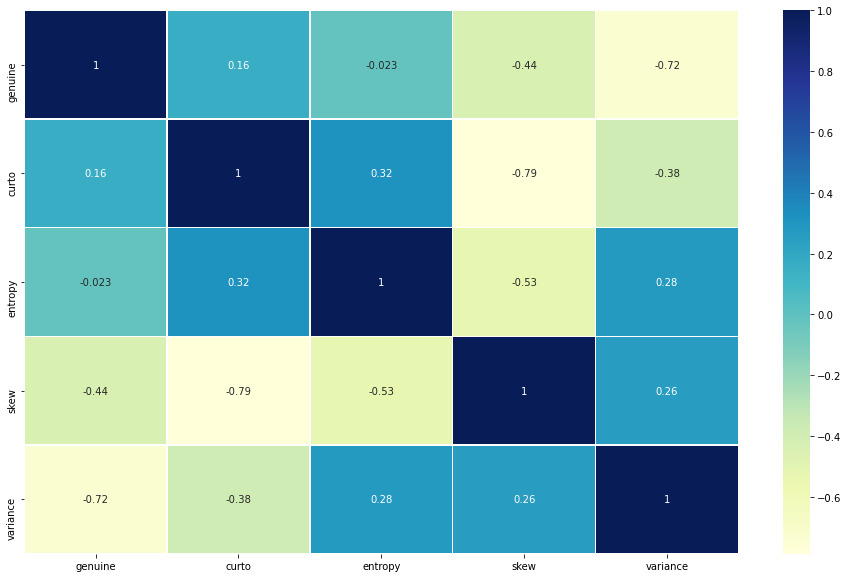

In [33]:
# Plotting correlation matrix against target variable to see if there are evidence to support
cor_df = df_norm.corr()                    # correlation of all attributes in df
k = 5                                      # Total number of attributes/features

# Sorting the columns by largest `MEDV` & extracting index
cols = cor_df.nlargest(k, "genuine")["genuine"]
cols_index = cols.index

# Setting figure & plotting
f, ax = plt.subplots(figsize = (16,10))     # Size of the figure

sns.heatmap(df_norm[cols_index].corr(), annot = True, linewidths = .5,
           cmap = "YlGnBu")

**Observations:**

By plotting out the heat map on the correlation between the variables, we can see that `curto` and `entropy` does have a very weak correlation with the `geniune` attribute. This supports our hypothesis that `L1 regularization (Lasso regression)` worked better for our dataset as it penalizes the weaker-correlated predictors.

## 9. Comparing results with K-Nearest Neighbour

Using [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), we can generate a model to compare it against our logistic regression models

In [34]:
# Construct knn model with default parameters
knn = KNeighborsClassifier()

# Fit model with our training dataset
knn.fit(X_train, y_train)

# Predict values of y_label (genuine) with knn model
y_pred_knn = knn.predict(X_test)

In [35]:
# Classification report for knn model with default hyperparameters
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       183

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



**Observations:**

The result with K-Nearest Neighbours classifier returns a perfect model that has 1.0 for `accuracy`, `precision`, `recall`, and `f1-score`. 

This indicates that the dataset is likely noise-free and the predictor variable is very well-clustered/grouped such as there are no incorrect prediction with the default value of `K = 5`